In [1]:
import cv2 
import os 
import glob
import json
import numpy as np
import matplotlib.pyplot as plt 


from tqdm import tqdm 
from module.utils import imread
from module.disp_measure import displacement_measure

In [2]:
sensor_num = 59
sensor_num = str(sensor_num)


img_list = glob.glob(os.path.join(r'imgs', sensor_num, '*.jpg'))

with open('params.json') as param_config_json : 
    param_config = json.load(param_config_json)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:46<00:00,  5.33s/it]


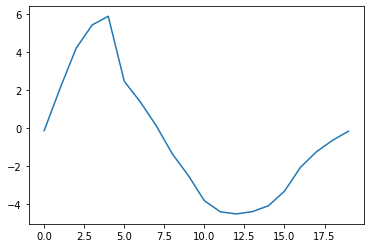

In [3]:
params = param_config[sensor_num]

result = [] 
src_img = imread(img_list[0])

for img_path in tqdm(img_list[:20]): 
    dest_img = imread(img_path)
    disp, dest_circles = displacement_measure(dest_img,
                                 src_img,
                                 min_rad = params['min_rad'],
                                 max_rad = params['max_rad'])
    
    result.append(disp)
    for dest_circle in dest_circles : 
        dest_img = cv2.circle(dest_img, tuple(np.asarray(dest_circle[:2], dtype =np.int64)), int(dest_circle[2]), (0,255,0), thickness=1, lineType=8, shift=0)
    cv2.imwrite(img_path[:-4] + '_with_circles_result.jpeg', dest_img)
    
collect_rslt = []
for rslt in result : 
    collect_rslt.append(rslt[0])
    
plt.plot(np.array(collect_rslt))

In [45]:
## check the circle detection accuracy 

param1 = 200
param2 = 14
min_rad = 77
max_rad = 83
img = imread(img_list[0]) 

# ret3, grey_img = cv2.threshold(grey_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
grey_img = cv2.adaptiveThreshold(grey_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
        cv2.THRESH_BINARY,11,10)


In [45]:
# th3 = 255 - th3

circles = cv2.HoughCircles(grey_img, 
                           cv2.HOUGH_GRADIENT,
                           1, 
                           max_rad*2, 
                           param1=param1,
                           param2=param2,
                           minRadius=min_rad,
                           maxRadius=max_rad)

# Draw circles that are detected. 
if circles is not None: 
  
    # Convert the circle parameters a, b and r to integers. 
    circles = np.uint16(np.around(circles)) 
  
    for pt in circles[0, :]: 
        a, b, r = pt[0], pt[1], pt[2] 
  
        # Draw the circumference of the circle. 
        cv2.circle(img, (a, b), r, (0, 255, 0), 2) 
  
        # Draw a small circle (of radius 1) to show the center. 
        cv2.circle(img, (a, b), 1, (0, 0, 255), 3) 
        cv2.imshow("Detected Circle", img) 
        cv2.waitKey(0) 
else:
        cv2.imshow('Circle is not detected', img)
        cv2.waitKey(0) 

NameError: name 'grey_img' is not defined

In [13]:
start_p = time.time()

sensitivity = 0.96
centers = []
r_estimated = []
metric = []
radiusRange = [35, 45]

A = imread(img_list[0]) 

centers, r_estimated, metric = imfindcircles(A, radiusRange,  ObjectPolarity = 'bright', sensitivity = 0.95)
